In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [32]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_output/",
    "plot_config":     "VBSOS",
    "cut":             "em_tight",
    "model_version":   "v2",
    "model_tag":       "model_sgd",
    "samples_version": "v2",
    "cols": ['btag_second',
             'detajj', 
             'detall',
             'eta1',
             'eta2',
             'jetpt1', 
             'jetpt2', 
             'dphill',
             'dphijj',
             'Mll',
             'met',
             'Zlep1', 
             'Zlep2',
             'dR_jl1',
             'dR_jl2'
            ]
}

In [33]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

In [34]:
import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [35]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [36]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [38]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

In [39]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [40]:
print("Number of background events:", len(X_bkg), "\n Number of signal events:", len(X_sig))

Number of background events: 108446 
 Number of signal events: 11171


In [41]:
X[~np.isfinite(X)] = 9999

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

In [43]:
# _ = plt.hist(W, bins=100)
# _ = plt.hist(W, bins=100, range=(0,2))

##  Balancing


In [44]:
config["test_size"] = 0.2
#config["val_size"]  = 0.5  ## test != val
config["val_size"]  = 0.0  ## test == val

X_train, X_temp, y_train, y_temp, W_train, W_temp , Wnn_train, Wnn_temp = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"])
#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [45]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_temp.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (95693, 15)
Test + Val dataset:  (23924, 15)


## SKLEARN - AVOVA F-Test

In [46]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_classif

import itertools

## This uses only public API, but is a real mess
#mask = [False for i in range (len(config["cols"]))]
#for varn  in range (len(config["cols"]) + 1):
#    a = SelectKBest(f_classif, k=varn)
#    a.fit(X_train, y_train)
#    mask_old = mask.copy()
#    mask = a.get_support()
#    mask_xor = [x ^ y for x,y in zip(mask, mask_old)]
#    print(varn, list(itertools.compress( config["cols"], mask_xor )))
        
## This uses a SelectKBest "private" member, but is faster and cleaner
selection = SelectKBest(f_classif, k=4)
selection.fit(X_train, y_train)
scores_df = pd.DataFrame({"score": selection.scores_, "varname": config["cols"]})


In [47]:
## visualize list of scores
#scores_df.sort_values(by=["score"], ascending=False)

<BarContainer object of 15 artists>

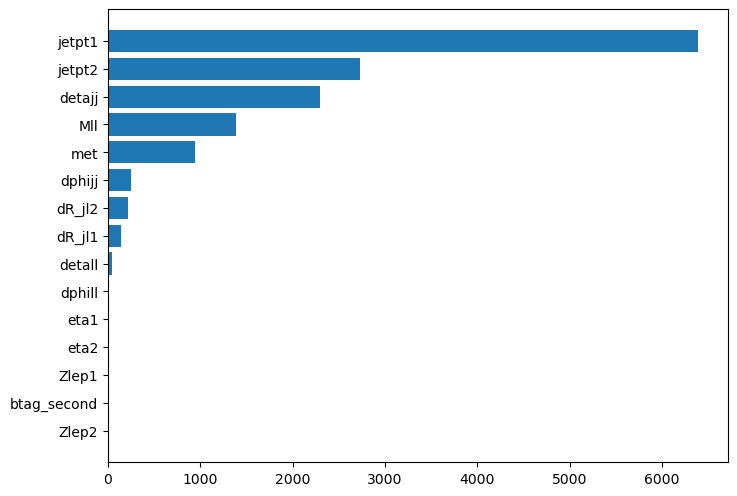

In [48]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

## visualize scores as barchart
s_df = scores_df.sort_values(by=["score"], ascending=True)
plt.barh(range(len(s_df["score"])), s_df["score"], tick_label=s_df["varname"])

## Keras model

In [49]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()

W0413 19:18:49.103154 139716901263168 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                480       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               

# SHAP

In [50]:
## https://github.com/slundberg/shap

# !pip3 install --user --upgrade shap
# 0.35

In [51]:
import shap

shap.initjs()

In [52]:
index1 = [x for x in range(len(X_train))]
X_train_pd = pd.DataFrame(X_train, index=index1, columns=config["cols"])
index2 = [x for x in range(len(X_train), len(X_train) + len(X_temp))]
X_temp_pd = pd.DataFrame(X_temp, index=index2, columns=config["cols"])

In [53]:
shap_lenght = 500
e = shap.DeepExplainer(model, X_train_pd.iloc[:shap_lenght,:])

In [54]:
shap_values = e.shap_values(X_temp[:shap_lenght])

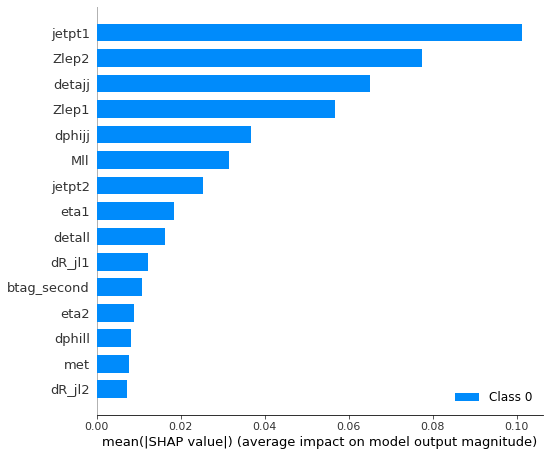

In [55]:
shap.summary_plot(shap_values, X_temp_pd.iloc[:,:], max_display=30)

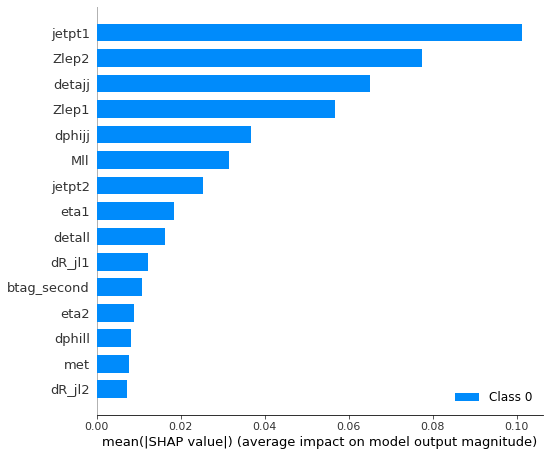

In [56]:
shap.summary_plot(shap_values, X_temp_pd.iloc[:,:], max_display=30, show=False)
plt.savefig(os.path.join(model_dir, "SHAP.png"))

# Altri plottini

In [24]:
index_event = 0
shap.force_plot(e.expected_value[0], shap_values[0][index_event], X_temp_pd.iloc[index_event,:])

In [25]:
shap.force_plot(e.expected_value, shap_values[0], X_temp_pd.iloc[:shap_lenght,:])

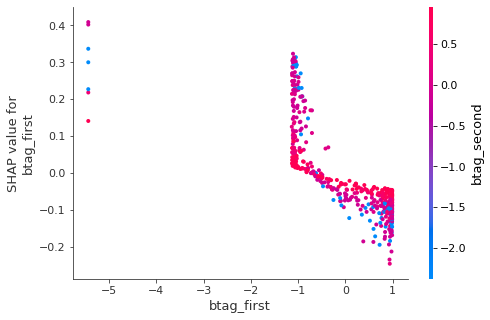

In [27]:
shap.dependence_plot("btag_first", shap_values[0], X_temp_pd.iloc[:shap_lenght,:])

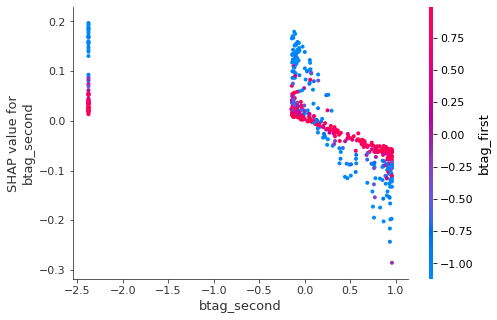

In [28]:
shap.dependence_plot("btag_second", shap_values[0], X_temp_pd.iloc[:shap_lenght,:])

In [ ]:
shap.summary_plot(shap_values[0], X_temp_pd.iloc[:shap_lenght,:])

In [ ]:
import os

#notebook_name = 'Evaluate_ANOVA_SHAP.ipynb'
#file_name = 'Evaluate_ANOVA_SHAP.html'
#import sys
#!{sys.executable} -m jupyter nbconvert --to html $notebook_name --output /eos/home-d/dmapelli/latino/ML_classification/$file_name

#print(os.getcwd())
#print(os.listdir(os.getcwd()))
print("rsync Evaluate_ANOVA_SHAP.html lxplus.cern.ch:" + model_dir + "/Evaluate_ANOVA_SHAP.html; mv Evaluate_ANOVA_SHAP.html Evaluate_ANOVA_SHAP.html_old" )

#os.rename('Evaluate_ANOVA_SHAP.html', model_dir + "/Evaluate_ANOVA_SHAP.html")
#print(model_dir + "/Evaluate_ANOVA_SHAP.html")

## No more used

### Evaluation

## Evaluation by sample